# Category Classifier

In [1]:
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

import json

## Data Classes

In [2]:
class Category:
    ELECTRONICS = "ELECTRONICS"
    BOOKS = "BOOKS"
    CLOTHING = "CLOTHING"
    GROCERY = "GROCERY"
    PATIO = "PATIO"

class Review:
    def __init__(self, text, category):
        self.category = category
        self.text = text

class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_category(self):
        return [x.category for x in self.reviews]
    
    def get_x(self, vectorizer):
        return vectorizer.transform(self.get_text())


## Load Data

In [3]:
file_names = [
    "./data/category/books.json",
    "./data/category/electronics.json",
    "./data/category/patio.json",
    "./data/category/clothing.json",
    "./data/category/grocery.json"
]
file_categories = [
    Category.BOOKS,
    Category.ELECTRONICS,
    Category.PATIO,
    Category.CLOTHING,
    Category.GROCERY
]

reviews = []
for i in range(len(file_names)):
    file_name = file_names[i]
    file_category = file_categories[i]
    with open(file_name) as f:
        for line in f:
            review_json = json.loads(line)
            review = Review(review_json["reviewText"], file_category)
            reviews.append(review)
            

## Prepare Data

In [4]:
train, test = train_test_split(reviews, test_size = 0.33, random_state = 42)

train_container = ReviewContainer(train)
test_container = ReviewContainer(test)

corpus = train_container.get_text()

vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

x_train = train_container.get_x(vectorizer)
y_train = train_container.get_category()

x_test = test_container.get_x(vectorizer)
y_test = test_container.get_category()

## Classification

### Linear SVM

In [5]:
from sklearn.svm import SVC

clf_svm = SVC(kernel = "linear", gamma = "auto")
clf_svm.fit(x_train, y_train)

print(test_container.get_text()[0])
print(clf_svm.predict(x_test[0])[0])

Very effective. Superb graphics. I bought the update package. Well worth it.
ELECTRONICS


### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(x_train, y_train)

print(test_container.get_text()[0])
print(clf_svm.predict(x_test[0])[0])

Very effective. Superb graphics. I bought the update package. Well worth it.
ELECTRONICS


### Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
clf_gnb.fit(x_train.toarray(), y_train)

print(test_container.get_text()[0])
print(clf_svm.predict(x_test[0])[0])

Very effective. Superb graphics. I bought the update package. Well worth it.
ELECTRONICS


### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(x_train, y_train)

print(test_container.get_text()[0])
print(clf_svm.predict(x_test[0])[0])

Very effective. Superb graphics. I bought the update package. Well worth it.
ELECTRONICS


## Evaluation

### Accuracy

In [9]:
import pandas as pd
import numpy as np

accuracies = [
    clf_svm.score(x_test, y_test),
    clf_dec.score(x_test, y_test),
    clf_gnb.score(x_test.toarray(), y_test),
    clf_log.score(x_test, y_test)
]

### F1 Scores

In [10]:
f1_scores = [
    f1_score(y_test, clf_svm.predict(x_test), average = None, labels = file_categories),
    f1_score(y_test, clf_dec.predict(x_test), average = None, labels = file_categories),
    f1_score(y_test, clf_gnb.predict(x_test.toarray()), average = None, labels = file_categories),
    f1_score(y_test, clf_log.predict(x_test), average = None, labels = file_categories)
]

In [11]:
df_data = f1_scores.copy()
df_columns = file_categories.copy()
acc = np.array(accuracies)
df_data = np.hstack((acc[:, np.newaxis], df_data))
df_columns.insert(0, "ACCURACY")
df_rows = ["svm", "decision tree", "gaussian nb", "logistic regression"]

pd.DataFrame(df_data, index = df_rows, columns = df_columns)

ACCURACY     BOOKS  ELECTRONICS     PATIO  CLOTHING  \
svm                  0.927879  0.968516     0.897959  0.916797  0.906942   
decision tree        0.711515  0.886567     0.574374  0.687898  0.672515   
gaussian nb          0.813333  0.834862     0.798220  0.798408  0.785479   
logistic regression  0.925455  0.966967     0.898678  0.909924  0.910741   

                      GROCERY  
svm                  0.951027  
decision tree        0.738654  
gaussian nb          0.852941  
logistic regression  0.941915

## Tuning Model (with Grid Search)

### SVM

In [12]:
from sklearn.model_selection import GridSearchCV

parameters_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 0.3, 1, 4, 8]}

svc = SVC()
clf_svm_opt = GridSearchCV(svc, parameters_svm, cv = 5)
clf_svm_opt.fit(x_train, y_train)

for param in parameters_svm.keys():
    print("Optimum value for %s: %s" % (param, clf_svm_opt.get_params()["estimator__" + param]))

Optimum value for kernel: rbf
Optimum value for C: 1.0


In [13]:
accuracy_opt = clf_svm_opt.score(x_test, y_test)

f1_score_opt = f1_score(y_test, clf_svm_opt.predict(x_test), average = None, labels = file_categories)
df_data_opt = np.hstack(([accuracy_opt], f1_score_opt))
df_columns_opt = df_columns
df_rows_opt = ["svm"]

pd.DataFrame(df_data_opt[:, np.newaxis].T, index = df_rows_opt, columns = df_columns_opt)

ACCURACY     BOOKS  ELECTRONICS     PATIO  CLOTHING   GROCERY
svm  0.927879  0.968516     0.897959  0.916797  0.906942  0.951027

## Saving Model

### Saving Model

In [14]:
import joblib

joblib.dump(vectorizer, "./models/category_vectorizer.pkl")
joblib.dump(clf_svm_opt, "./models/category_classifier.pkl")

print("Saved Models")

Saved Models


### Load Model

In [15]:
import joblib

loaded_vectorizer = joblib.load("./models/category_vectorizer.pkl")
loaded_clf = joblib.load("./models/category_classifier.pkl")

test_set = ["it was an awesome read", "loved the necklace", "the food taseted stale"]
new_test = loaded_vectorizer.transform(test_set)

predictions = loaded_clf.predict(new_test)

for i in range(len(test_set)):
    print("%s: %s" % (test_set[i], predictions[i]))

it was an awesome read: BOOKS
loved the necklace: CLOTHING
the food taseted stale: GROCERY


## Confusion Matrix

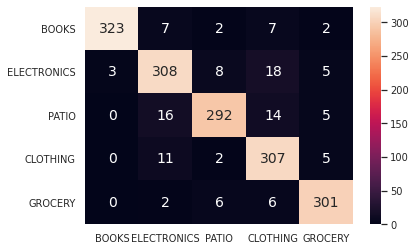

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

y_pred = loaded_clf.predict(x_test)

labels = [
    Category.BOOKS,
    Category.ELECTRONICS,
    Category.PATIO,
    Category.CLOTHING,
    Category.GROCERY
]

cm = confusion_matrix(y_test, y_pred, labels = labels)
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

sn.set(font_scale = 0.9)
sn.heatmap(df_cm, annot = True, annot_kws = {"size": 14}, fmt = "d")
plt.show()